# Map human scRNA-seq kidney on mouse Visium kidney.

In [1]:
# basic imports
import pandas as pd
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import scanpy as sc
import torch
import scipy
import matplotlib.patches as mpatches
import seaborn as sns
from IPython.display import display

# torch imports
from torch.nn.functional import softmax, cosine_similarity, sigmoid

# add `Tangram` to path
import sys
sys.path.append("../") 

# Tangram imports
import mapping.utils
import mapping.mapping_optimizer
import mapping.plot_utils

In [2]:
'Folder where data are stored'
fld = '.'
fld = os.path.join(home, 'kidney_dataset')
assert os.path.isdir(fld)

In [3]:
'Load snRNA-seq data (AnnData format)'
path = os.path.join(fld, 'human_kidney_map.h5ad')
ad_sc = sc.read_h5ad(path)
# Convert mouse genes to human convention
ad_sc.var.index = ad_sc.var.index.str.upper()
ad_sc.var_names_make_unique()

In [4]:
'Load spatial Visium data (AnnData format)'
path = os.path.join(fld, 'visium_mouse_kidney_filtered.h5ad')
ad_sp = sc.read_h5ad(path)
ad_sc.var_names_make_unique()

# filter obs in ROI
mask = ad_sp.obs.in_ROI == True
ad_sp.obs = ad_sp.obs[mask]

# there are no empty voxel
sums = np.sum(ad_sp.X, axis=1).A1
assert np.sum(sums == 0) == 0

# take list of HV genes
assert ad_sc.var.highly_variable.all()
hv_genes = ad_sc.var.index.values

# Convert mouse genes to human convention
ad_sp.var.index = ad_sp.var.index.str.upper()

# Only shared genes between visium and sn
mask = ad_sp.var.index.isin(hv_genes)
ad_sp = ad_sp[:, mask]
ad_sp

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/tbiancal/miniconda3/envs/dev/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


View of AnnData object with n_obs × n_vars = 1438 × 1654
    obs: 'in_ROI', 'frame_x', 'frame_y', 'x_fu', 'y_fu', 'x_hi', 'y_hi', 'x_lo', 'y_lo'
    var: 'gene_ids'

In [5]:
'Annotate marker genes on Visium'
mask = ad_sc.var.marker
marker_genes = ad_sc.var[mask].index.values
ad_sp.var['marker'] = ad_sp.var.index.isin(marker_genes)
ad_sp.var['marker'].sum()

Trying to set attribute `.var` of view, copying.


781

In [6]:
'Restrict ad_sc on shared genes and reindex as ad_sp'
hv_genes = ad_sp.var.index.values
mask = ad_sc.var.index.isin(hv_genes)
ad_sc = ad_sc[:, mask]
ad_sc.var = ad_sc.var.reindex(ad_sp.var.index)

***
## Feature selection

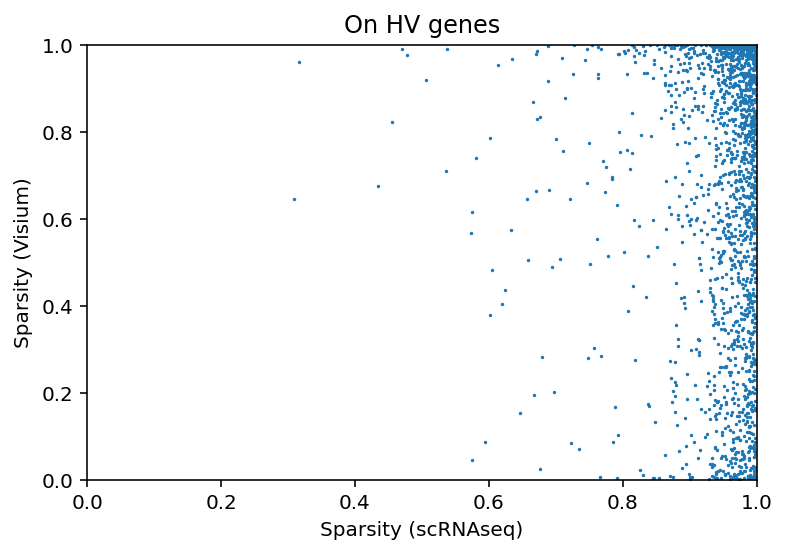

In [98]:
'Compute gene sparsity across datasets'
sparsity_sc = np.sum((ad_sc.X == 0), axis=0) / ad_sc.n_obs
sparsity_sp = np.sum((ad_sp.X.toarray() == 0), axis=0) / ad_sp.n_obs
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Sparsity (scRNAseq)');
plt.ylabel('Sparsity (Visium)');
plt.title('On HV genes')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.scatter(x=sparsity_sc, y=sparsity_sp, s=.5);

In [93]:
'Filter genes'
# take out genes sparse in sc and not in Visium
mask_1 = sparsity_sc > 0.9
mask_2 = sparsity_sp < 0.5
mask = mask_1 & mask_2
mask = ~mask
total_mask = mask

# take out super sparse genes
mask_1 = sparsity_sc > 0.97
mask_2 = sparsity_sp > 0.97
mask = mask_1 & mask_2
mask = ~mask
total_mask = total_mask & mask

# take out genes sparse in Visium and not in sc
mask_1 = sparsity_sc < 0.5
mask_2 = sparsity_sp > 0.6
mask = mask_1 & mask_2
mask = ~mask
total_mask = total_mask & mask

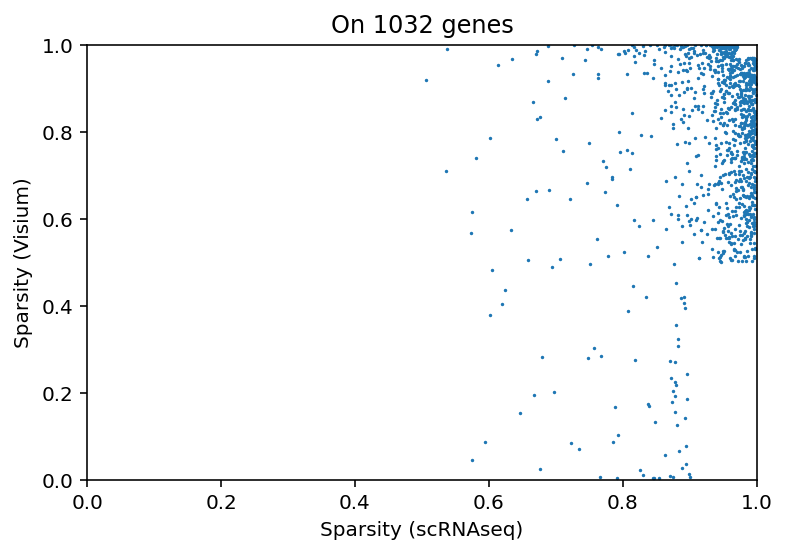

In [99]:
sparsity_sc = np.sum((ad_sc[:, total_mask].X == 0), axis=0) / ad_sc.n_obs
sparsity_sp = np.sum((ad_sp[:, total_mask].X.toarray() == 0), axis=0) / ad_sp.n_obs
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Sparsity (scRNAseq)');
plt.ylabel('Sparsity (Visium)');
plt.title('On ' + str(total_mask.sum()) + ' genes')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.scatter(x=sparsity_sc, y=sparsity_sp, s=.5); 

In [121]:
ad_sc_fl = ad_sc[:, total_mask]
ad_sp_fl = ad_sp[:, total_mask]

known_markers = [
    'CYRAB', 'NAPSA', 'NDUFB8', 'COXBA', 'HBB-BS', 'SERPINA1F'
]

[gene in list(ad_sc_fl.var.index.values) for gene in known_markers]

/home/tbiancal/miniconda3/envs/dev/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


[False, False, False, False, False, False]

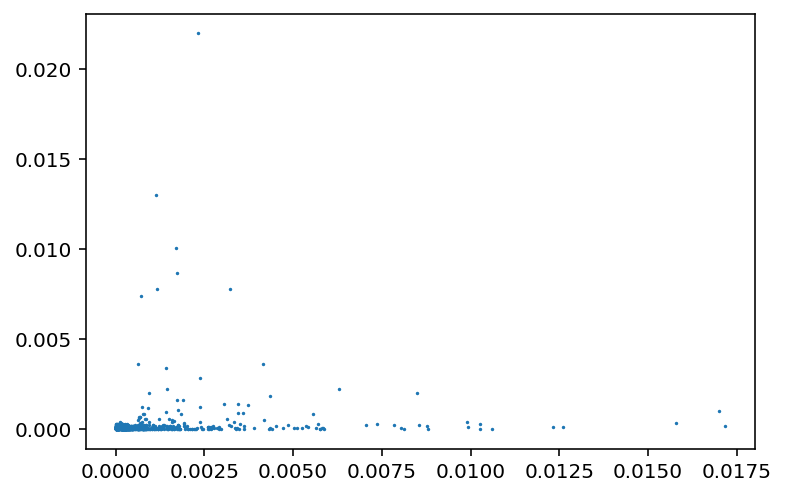

In [124]:
sparsity_sc = np.sum(ad_sc_fl.X, axis=0) / np.sum(ad_sc.X)
sparsity_sp = np.sum(ad_sp_fl.X.toarray(), axis=0) / np.sum(ad_sp.X)
# plt.xscale('log')
# plt.yscale('log')
# plt.xlabel('Sparsity (scRNAseq)');
# plt.ylabel('Sparsity (Visium)');
# plt.title('On HV genes')
plt.scatter(x=sparsity_sc, y=sparsity_sp, s=.5);

In [53]:
mask = ad_sc.var.marker
ad_sc_marker = ad_sc[:, mask]
mask = ad_sp.var.marker
ad_sp_marker = ad_sp[:, mask]
assert ad_sp_marker.var.index.equals(ad_sc_marker.var.index)

/home/tbiancal/miniconda3/envs/dev/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


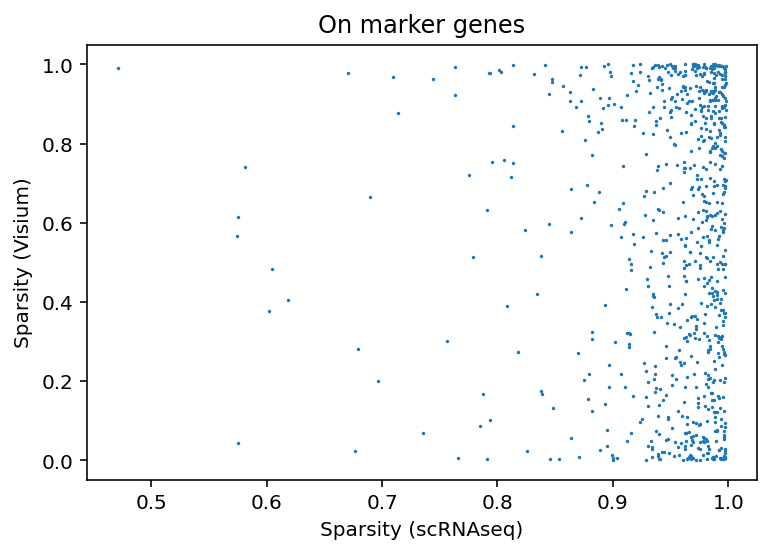

In [54]:
sparsity_sc = np.sum((ad_sc_marker.X == 0), axis=0) / ad_sc_marker.n_obs
sparsity_sp = np.sum((ad_sp_marker.X.toarray() == 0), axis=0) / ad_sp_marker.n_obs
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Sparsity (scRNAseq)');
plt.ylabel('Sparsity (Visium)');
plt.title('On marker genes')
plt.scatter(x=sparsity_sc, y=sparsity_sp, s=.5);

***

In [7]:
ad_sc_fl = ad_sc
ad_sp_fl = ad_sp

In [9]:
'Allocate matrices and select device'
S = np.array(ad_sc_fl.X, dtype='float32')
G = np.array(ad_sp_fl.X.toarray(), dtype='float32')
d = np.zeros(ad_sp_fl.n_obs)
device = torch.device('cuda:0')  # for gpu

In [10]:
'Define Tangram hyperparameters'
## TODO pars not in manuscript
hyperparm = {
    'lambda_d' : 0, # KL (ie density) term
    'lambda_g1' : 1, # gene-voxel cos sim
    'lambda_g2' : 1, # voxel-gene cos sim
    'lambda_r' : 0, # regularizer: penalize entropy
#     'lambda_count' : 0, # regularizer: number of cells is fixed (ie cells is not given HP no. cells no. voxels)
#     'lambda_f_reg' : 0,  # regularizer: filter values are Boolean
}
learning_rate = 0.1
num_epochs = 6000

- Is `MapperConstrained` the same as `Mapper` w/o filter? NO: il filtro c'e' sempre negli altri terms della loss
-  Forse chiamarlo `MapperWithFilter`

In [11]:
'Create mapping object' 
# Arguments: matrices, device, all hyperaparameters'
# mapper = mapping.mapping_optimizer.MapperConstrained(
mapper = mapping.mapping_optimizer.Mapper(
    S=S, G=G, d=d, device=device, 
    **hyperparm, 
#     target_count = space_data.obs.cell_count.sum()
)

TODO: user interrupts and results are saved.
- Save stuff in objects.

In [15]:
'Train Tangram'
# The output are the various terms in the loss function (see manuscript).
# density term, gene-voxel cosine similarity, voxel-gene cosine similarity, count term, F regularizer term
# all loss terms are printed normalizing their weight (ie the hyperaparameter)
output = mapper.train(learning_rate=learning_rate, num_epochs=6000)

nan 0.5031980276107788 0.0799766555428505
nan 0.7067281007766724 0.17142829298973083
nan 0.7071700692176819 0.18803590536117554
nan 0.7070702314376831 0.19282525777816772
nan 0.7068238854408264 0.195505291223526
nan 0.7067121267318726 0.1969950795173645
nan 0.7065236568450928 0.19795607030391693
nan 0.7064075469970703 0.19868364930152893
nan 0.706061065196991 0.1996215134859085
nan 0.7057873010635376 0.20043915510177612
nan 0.7057035565376282 0.20087018609046936
nan 0.7055848240852356 0.2013014853000641
nan 0.7054530382156372 0.20169366896152496
nan 0.7052508592605591 0.20212776958942413
nan 0.705095112323761 0.20250874757766724
nan 0.7049808502197266 0.20280446112155914
nan 0.7049397826194763 0.20296169817447662
nan 0.7049398422241211 0.20305201411247253
nan 0.7048422694206238 0.20327427983283997
nan 0.7048460841178894 0.20331795513629913
nan 0.7047650814056396 0.20350921154022217
nan 0.7047063112258911 0.2036294788122177
nan 0.7046930193901062 0.20369505882263184
nan 0.70458644628524

In [16]:
'Annotation transfer from snRNAseq to spatial data'
# Use `mapping.utils.transfer_annotations_prob_filter`to transfer annotations onto space.
# Here, we transfer subclasses (ie cell types).
df_classes = mapping.utils.one_hot_encoding(ad_sc.obs['subsampling.label'])
prob_assign = mapping.utils.transfer_annotations_prob_filter(output, F_out, df_classes)
prob_assign.head()

,Myofibroblast,Podocyte,LOH,Monocyte/macrophage,Dendritic cell,TAL,NK cell,Arteriolar EC,Peritubular EC,Glomerular EC,...,Myocyte,aIC,CD8+ T cell,Proximal tubule (ALDOB-high),DCT,B cell,bIC,CD4+ T cell,PC,Dividing
0,0.000085,4.962413e-08,0.000384,0.000002,5.815014e-08,1.856212e-07,0.000224,0.000101,1.482203e-07,0.000699,...,4.263059e-08,0.001200,0.000128,0.000234,2.310691e-04,2.069187e-04,6.189030e-08,0.000083,0.000363,2.704412e-08
1,0.626329,1.080166e-01,0.205596,0.174375,1.464213e-01,4.058690e-01,0.231946,0.214073,4.473391e-01,0.350301,...,3.343677e-07,0.523528,0.754761,1.697885,1.519747e-07,2.544297e-07,4.193431e-02,0.351233,2.180893,6.185230e-08
2,0.453577,1.772924e-01,0.616533,1.204138,5.734136e-01,1.100659e+00,0.971520,0.478703,1.102194e+00,0.491703,...,9.818192e-02,0.576817,1.497611,6.240965,1.039231e-01,1.084527e-01,1.693745e-01,1.245536,0.385472,6.044179e-07
3,0.094612,1.199234e-01,0.027298,0.055504,1.862380e-02,1.235035e-01,0.137080,0.132759,9.858794e-02,0.036402,...,2.196099e-07,0.319257,0.064023,0.275888,1.372052e-07,1.379845e-02,7.690055e-02,0.156171,0.974535,3.015071e-02
4,0.559068,2.394474e-01,1.877711,0.739095,9.782636e-01,1.717886e+00,1.203222,0.322166,1.064575e+00,0.823681,...,3.942921e-01,3.133739,1.248786,8.373502,5.398547e-01,4.082178e-01,1.602378e-01,4.465334,0.315253,7.021200e-03


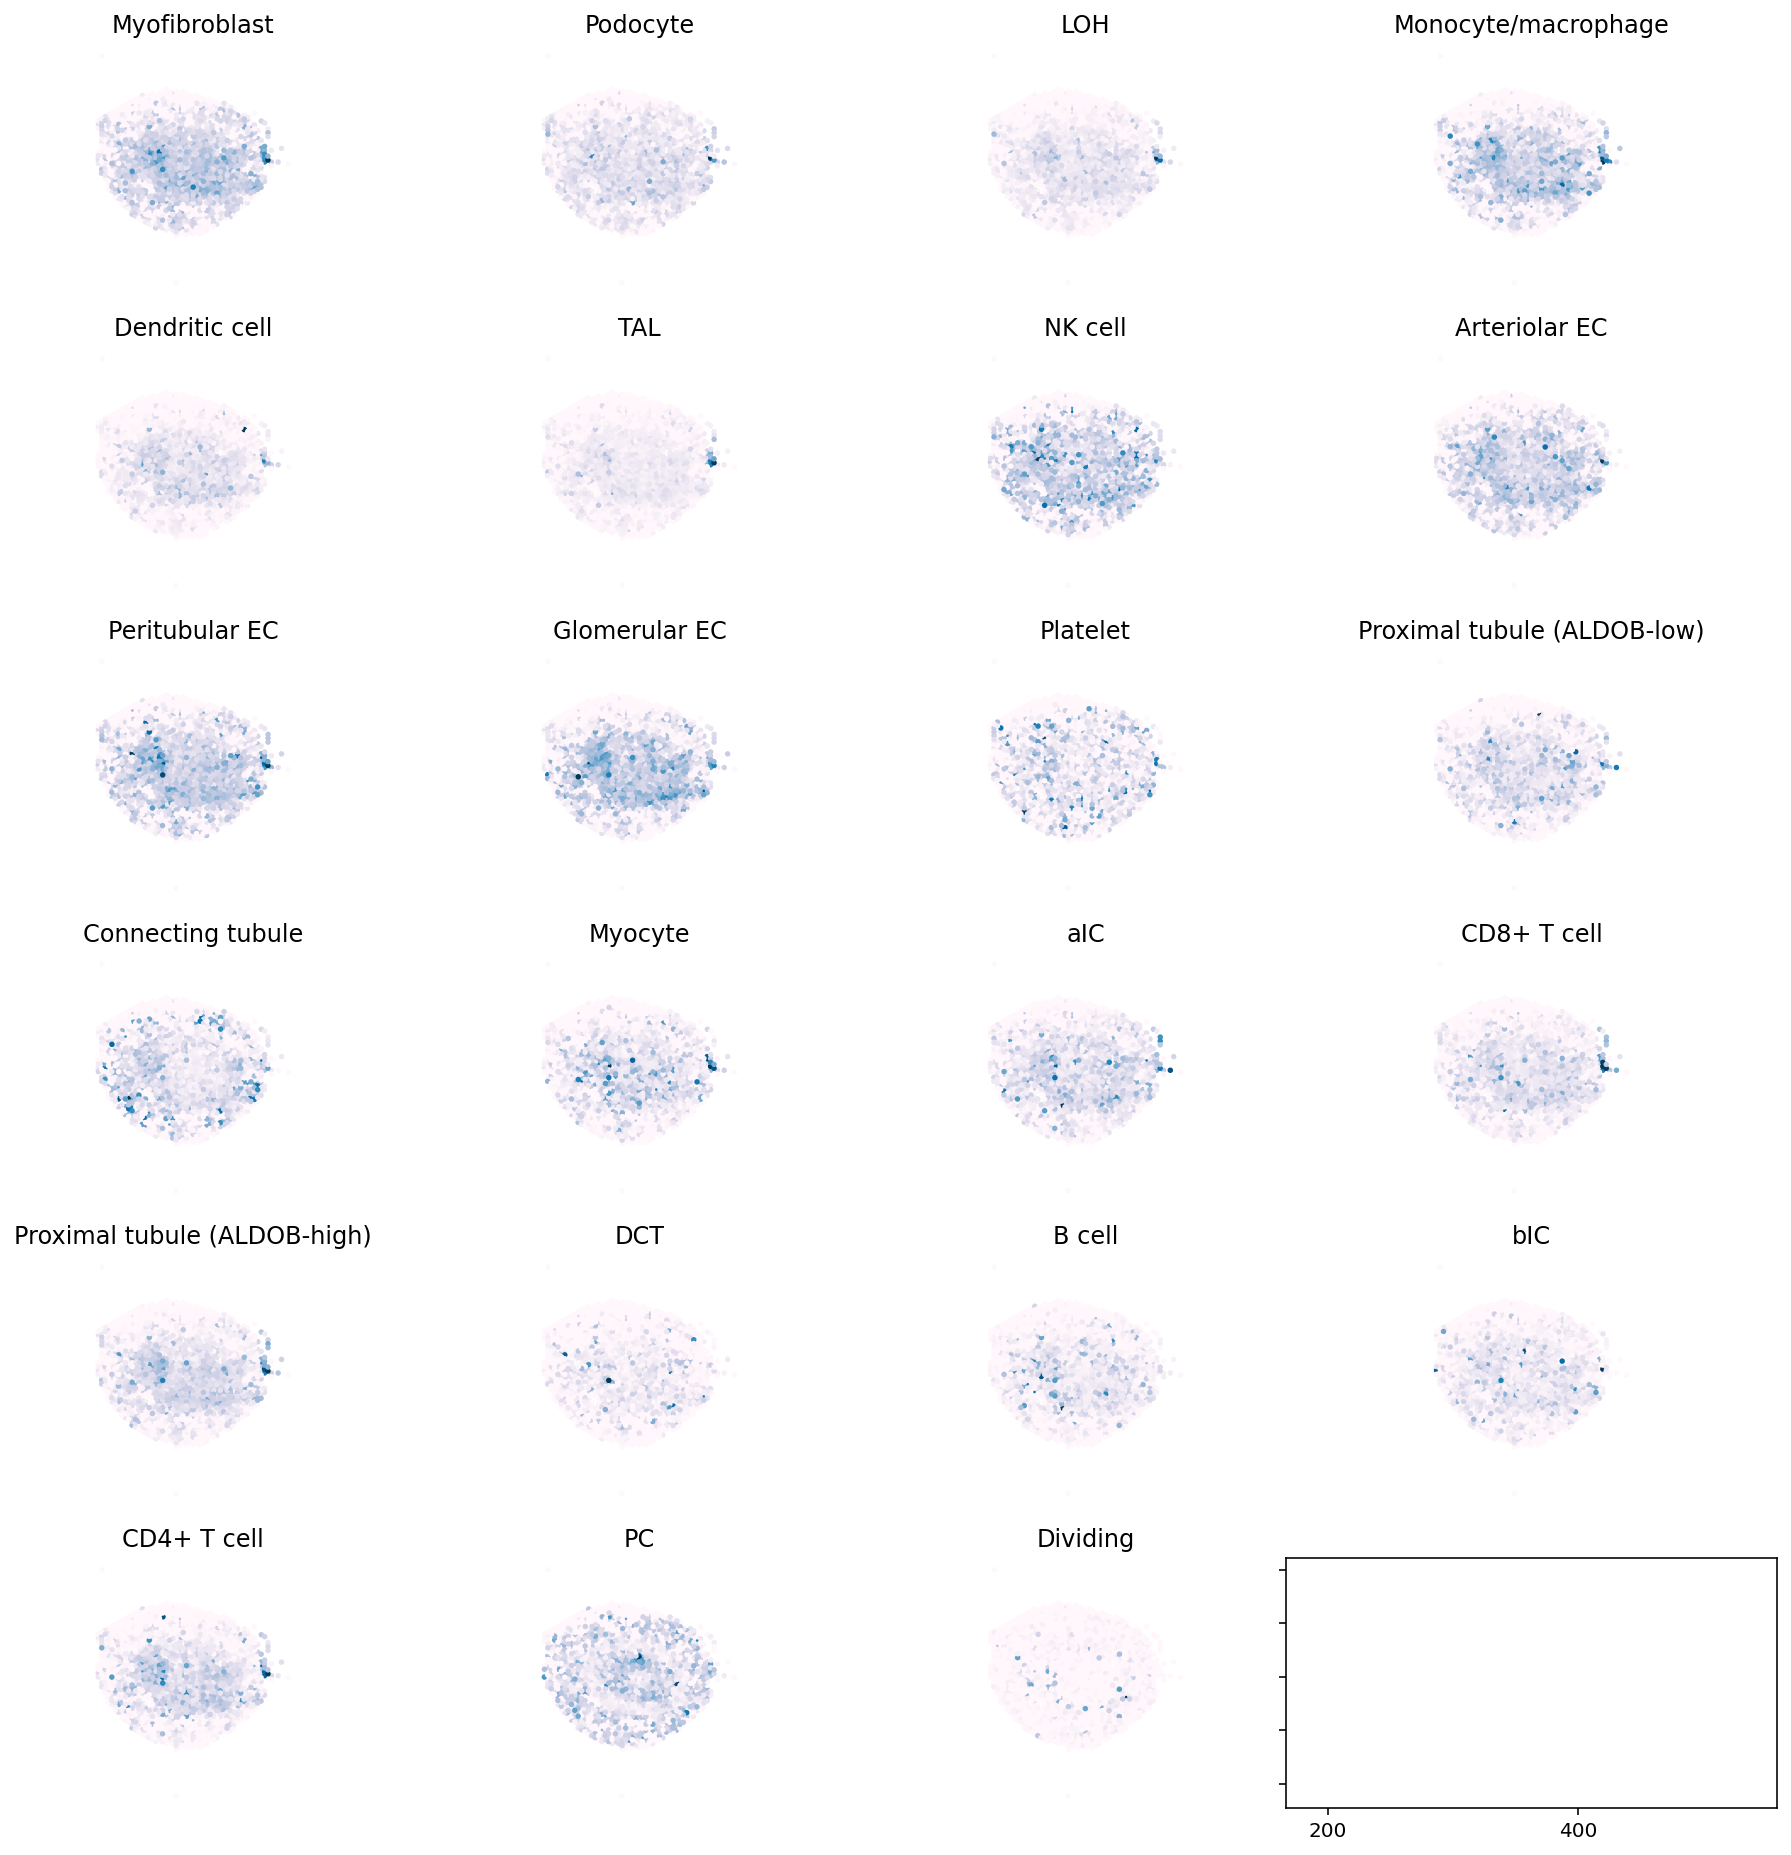

In [17]:
cell_types = list(ad_sc.obs['subsampling.label'].unique())

fig, axs = plt.subplots(nrows=6, ncols=4, figsize=(13, 13), sharex=True, sharey=True)
for ax, ct in zip(axs.flatten(), cell_types):
    ax.scatter(x=ad_sp.obs.x_lo, 
               y=ad_sp.obs.y_lo, 
               c=prob_assign[ct], 
               s=3, 
               cmap='PuBu');
    ax.set_title(ct)
    ax.set_aspect(1)
    ax.axis('off');
plt.tight_layout()

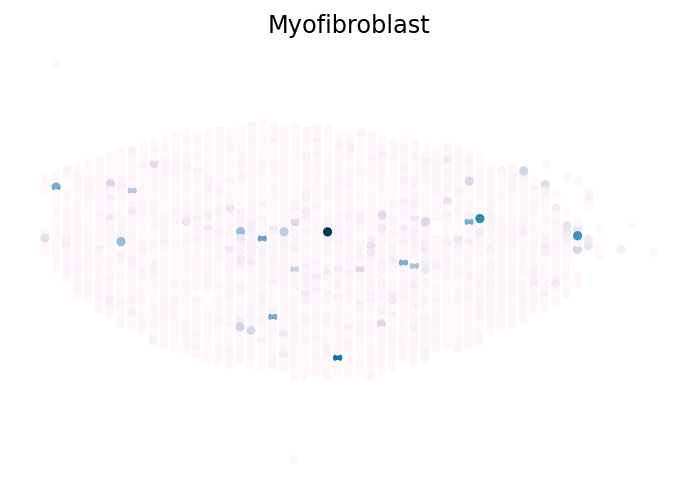

In [14]:
plt.scatter(x=ad_sp.obs.x_lo, 
            y=ad_sp.obs.y_lo, 
            c=prob_assign['Myofibroblast'], 
            s=13, 
            cmap='PuBu');
plt.title('Myofibroblast')
plt.axis('off');

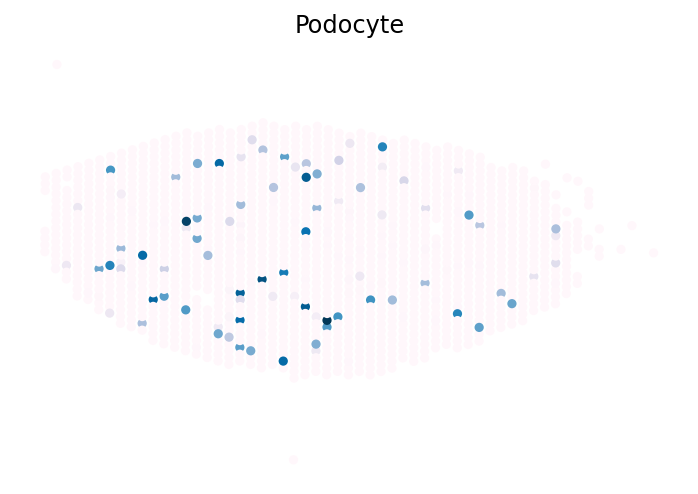

In [15]:
cell_type = 'Podocyte'
plt.scatter(x=ad_sp.obs.x_lo, 
            y=ad_sp.obs.y_lo, 
            c=prob_assign[cell_type], 
            s=13, 
            cmap='PuBu');
plt.title(cell_type)
plt.axis('off');

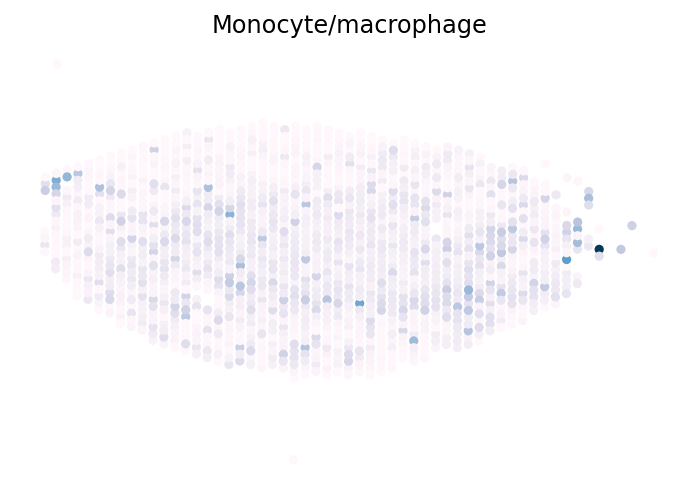

In [16]:
cell_type = 'Monocyte/macrophage'
plt.scatter(x=ad_sp.obs.x_lo, 
            y=ad_sp.obs.y_lo, 
            c=prob_assign[cell_type], 
            s=13, 
            cmap='PuBu');
plt.title(cell_type)
plt.axis('off');